In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Fun with Gaia!

### Loading in the data

`sphericalshell_file` is a slice of 3,000,000 stars at 1 kpc. I have not played around with this yet.

`neighborhood_file` contains all stars between 1 pc and 100 pc in distance. This is what is use in the analysis that follows.

Below each file is the ADQL query that provided the csv file used.

In [2]:
sphericalshell_file = '1525882772783O-result.csv'
"""
SELECT TOP 3000000
source_id,ra,ra_error,dec,dec_error,l,b,parallax,parallax_error,phot_g_mean_mag,bp_rp,radial_velocity,radial_velocity_error,phot_variable_flag,teff_val,a_g_val
FROM gaiadr2.gaia_source WHERE (parallax>.02 AND parallax<1) ORDER BY parallax DESC
"""

neighborhood_file = '1525890567582O-result.csv'
"""
SELECT TOP 3000000
source_id,ra,ra_error,dec,dec_error,l,b,parallax,parallax_error,phot_g_mean_mag,bp_rp,radial_velocity,radial_velocity_error,phot_variable_flag,teff_val,a_g_val
FROM gaiadr2.gaia_source WHERE (parallax>10 AND parallax<1000) ORDER BY parallax DESC
"""
df = pandas.read_csv(neighborhood_file)
df = df[df.parallax/df.parallax_error>10]

In [3]:
print('All objects from {:.2f} pc to {:.2f} pc'.format(1/df.parallax.max()*1000, 1/df.parallax.min()*1000))

All objects from 1.02 pc to 100.00 pc


## A first look at the data

Where are the stars in our sample? First, let's see what it looks like if you plot it on a Mollweide projection.

/Users/Elaad/anaconda2/envs/gaia-hack/lib/python3.6/site-packages/matplotlib/projections/geo.py:485: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


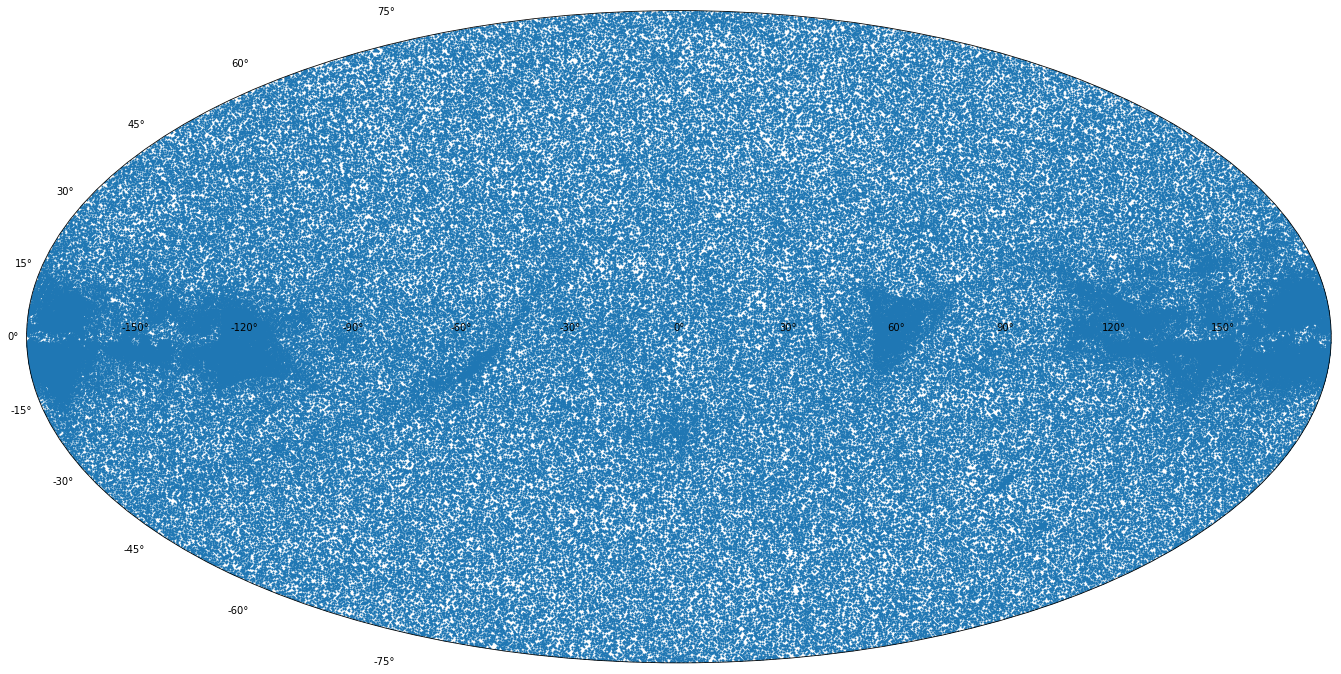

In [4]:
fig = plt.figure()
fig.set_size_inches(24, 12)
ax = fig.add_subplot(111, projection='mollweide')
ax.scatter(np.deg2rad(df.l-180), np.deg2rad(df.b), s=1)
#ax.set_xlabel('Galactic Longitude [Deg]', fontsize=18)
#ax.set_ylabel('Galactic Latitute [Deg]', fontsize=18)

That wasn't very informative. Let's see what happens if you histogram it (logarithmic normalization).

Text(0,0.5,'Galactic Latitute [Deg]')

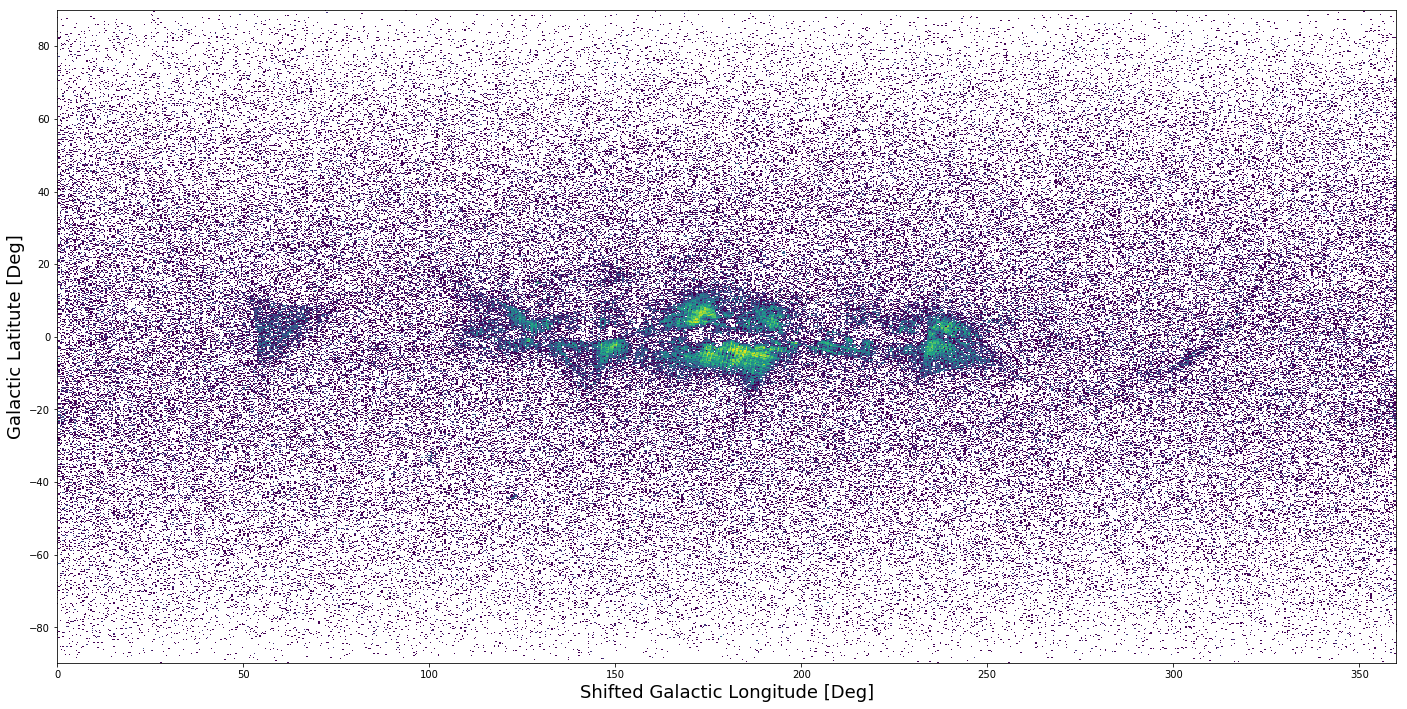

In [5]:
fig = plt.figure()
fig.set_size_inches(24, 12)
ax = fig.add_subplot(111)#, projection='mollweide')
ax.hist2d((df.l+180)%360, df.b, bins=1000, norm=colors.LogNorm())
ax.set_xlabel('Shifted Galactic Longitude [Deg]', fontsize=18)
ax.set_ylabel('Galactic Latitute [Deg]', fontsize=18)

Unsurprisingly, most stars lie in the plane of the disk. This is what it looks like if you plot using right ascension and declination.

Text(0,0.5,'Declination')

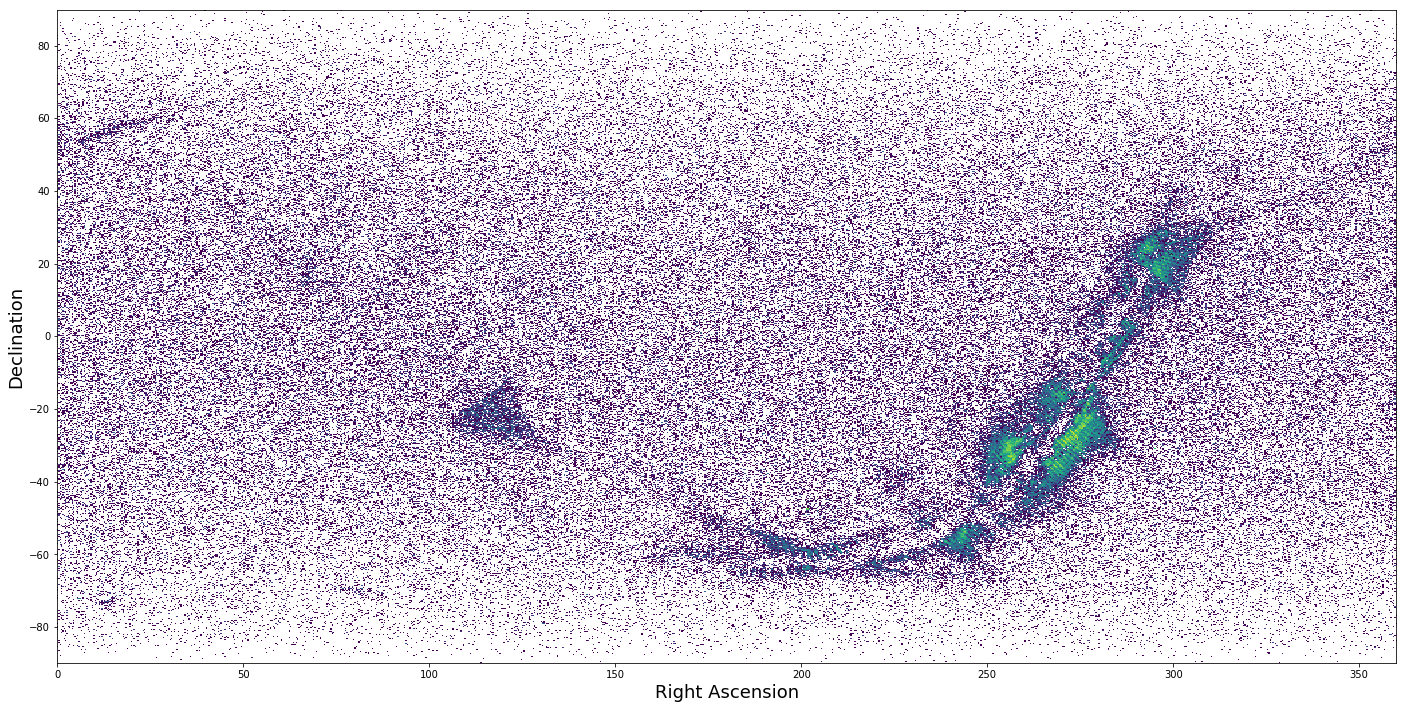

In [6]:
fig = plt.figure()
fig.set_size_inches(24, 12)
ax = fig.add_subplot(111)#, projection='mollweide')
ax.hist2d(df.ra, df.dec, bins=1000, norm=colors.LogNorm())
ax.set_xlabel('Right Ascension', fontsize=18)
ax.set_ylabel('Declination', fontsize=18)

### HR Diagrams

First, let's bin the stars in the HR diagram (Absolute G magnitude vs. color)

Text(0,0.5,'M$_G$')

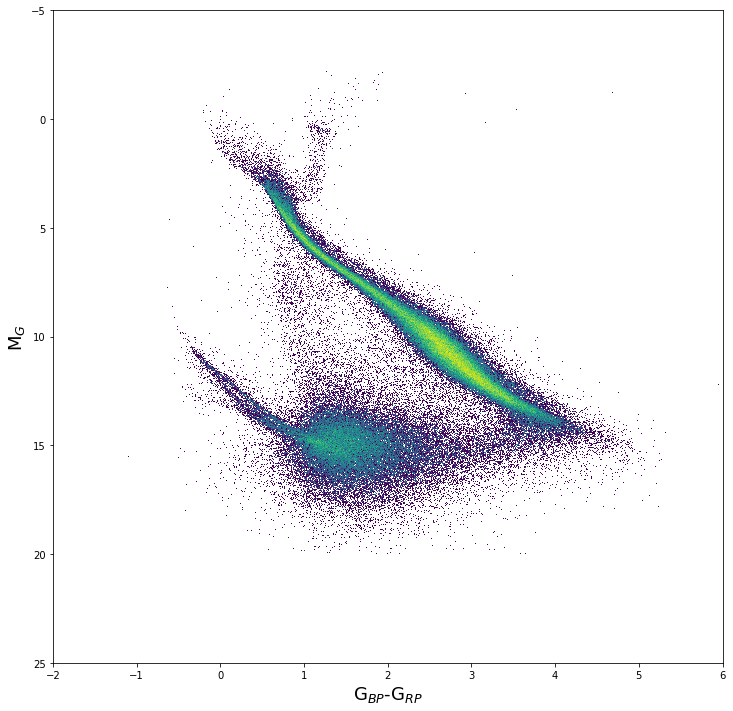

In [7]:
fig = plt.figure()
fig.set_size_inches(12, 12)
ax = fig.add_subplot(111)
ax.hist2d(df.bp_rp[df.bp_rp.notna()], -5*np.log10(1/df.parallax[df.bp_rp.notna()]*1000)+5+df.phot_g_mean_mag[df.bp_rp.notna()], bins=1000, range=((-2, 6), (-5, 20)), norm=colors.LogNorm())
plt.ylim([25, -5])
ax.set_xlabel('G$_{BP}$-G$_{RP}$', fontsize=18)
ax.set_ylabel('M$_G$', fontsize=18)

That's good! We see lots of main sequence stars, some white dwarfs, and what appear to be a small smattering of red giant stars. Are there any selection effects? Let's plot these and color them by their distance.

Text(0,0.5,'M$_G$')

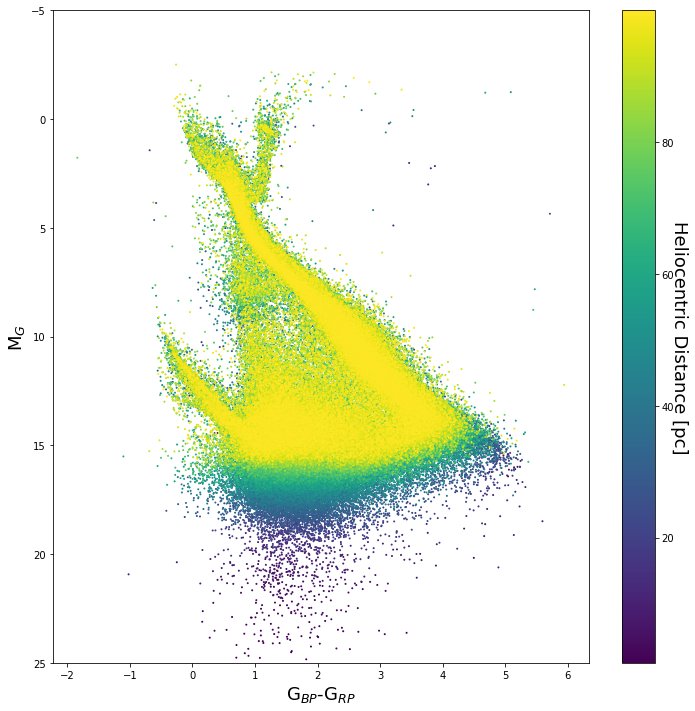

In [8]:
fig = plt.figure()
fig.set_size_inches(12, 12)
ax = fig.add_subplot(111)
cax = ax.scatter(df.bp_rp[df.bp_rp.notna()], -5*np.log10(1/df.parallax[df.bp_rp.notna()]*1000)+5+df.phot_g_mean_mag[df.bp_rp.notna()], c=1/df.parallax[df.bp_rp.notna()]*1000, s=1)
cbar = fig.colorbar(cax)
cbar.set_label('Heliocentric Distance [pc]', rotation=270, fontsize=18, labelpad=14)
plt.ylim([25, -5])
ax.set_xlabel('G$_{BP}$-G$_{RP}$', fontsize=18)
ax.set_ylabel('M$_G$', fontsize=18)

### Velocities in the solar neighborhood

Do we expect to see any stellar streams near the Sun? Are there distinct populations? Let's take a look at the very nearby neighborhood - 10 pc are so.

In [9]:
close_rad = 10. # upper radius in parsecs to plot in 3D
close_stars = df[df.parallax>1./(close_rad/1000.)]

Defining proper motion and calculating the physical tangential velocities in km/s.

In [10]:
vra = np.cos(close_stars.dec*np.pi/180.) * close_stars.pmra * 1.e-3 / 360. * np.pi/180. * 1000./close_stars.parallax * 3.086e13 / 3.154e7
vdec = close_stars.pmdec * 1.e-3 / 360. * np.pi/180. * 1000./close_stars.parallax * 3.086e13 / 3.154e7

vpm = np.sqrt((np.cos(close_stars.dec*np.pi/180.)*close_stars.pmra)**2 + close_stars.pmra**2)
vtan = np.sqrt(vra**2 + vdec**2)

Let's plot this (ignore the fact that we're mixing units!). All stars within the neighborhood are plotted at their RA and Dec, and arrows are plotted to represent their physical velocity relative to the Sun. They are colored by their distance from us.

Text(0,0.5,'Declination')

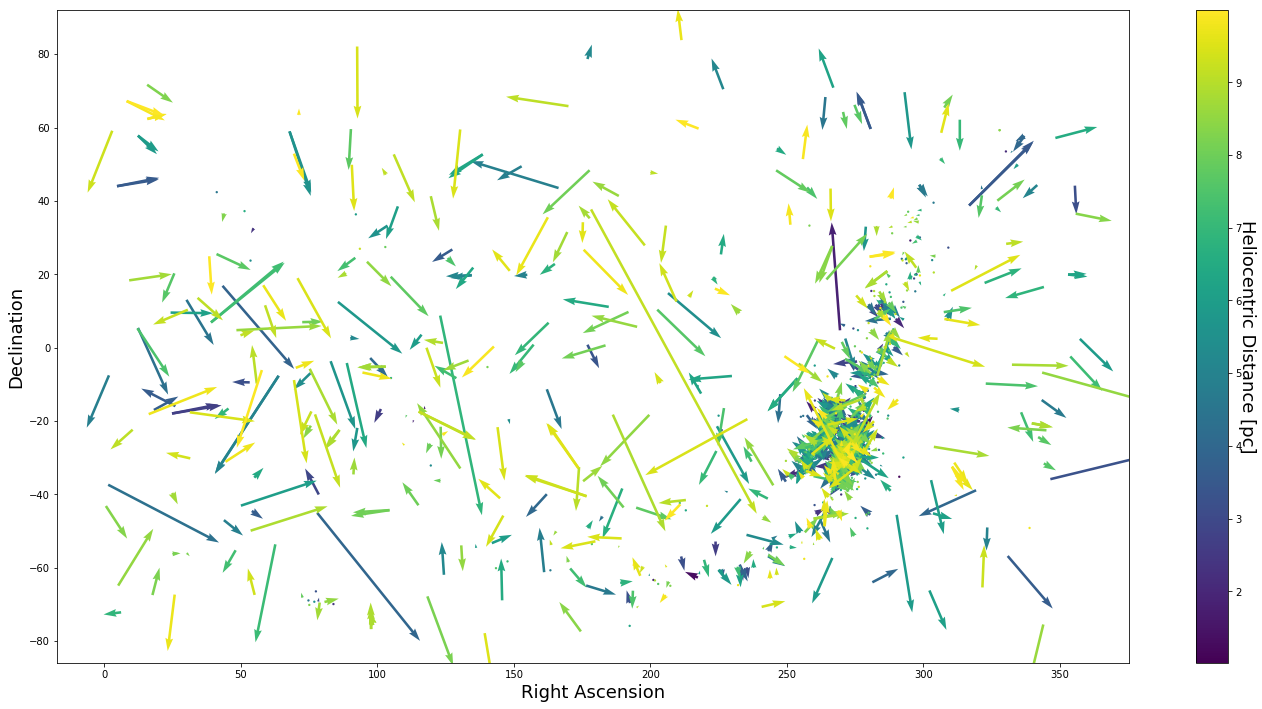

In [11]:
fig = plt.figure()
fig.set_size_inches(24, 12)
ax = fig.add_subplot(111)
#cax = ax.quiver(close_stars.ra, close_stars.dec, np.cos(close_stars.dec*np.pi/180.)*close_stars.pmra, close_stars.pmdec, 1000./close_stars.parallax)
cax = ax.quiver(close_stars.ra, close_stars.dec, vra, vdec, 1000./close_stars.parallax)
cbar = fig.colorbar(cax)
cbar.set_label('Heliocentric Distance [pc]', rotation=270, fontsize=18, labelpad=14)
ax.set_xlabel('Right Ascension', fontsize=18)
ax.set_ylabel('Declination', fontsize=18)

We seem to see two populations - halo stars (moving every which way), and disk stars, generally corotating with us.

Text(0,0.5,'Dec')

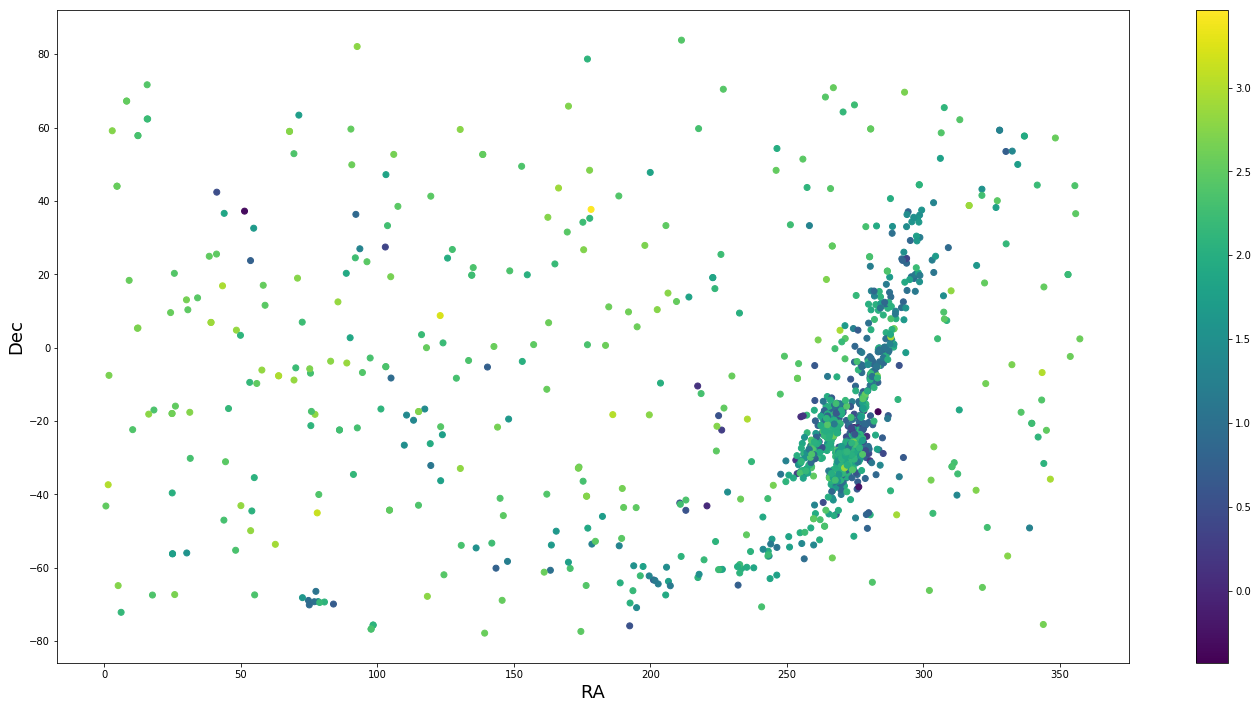

In [12]:
fig = plt.figure()
fig.set_size_inches(24, 12)
ax = fig.add_subplot(111)#, projection='mollweide')
cax = ax.scatter(close_stars.ra, close_stars.dec, c=np.log10(vtan))
cbar = fig.colorbar(cax)
ax.set_xlabel('RA', fontsize=18)
ax.set_ylabel('Dec', fontsize=18)